# SMS Spam Detection

Spam filtering using machine learning has become common among email providers. However, spam filtering of SMS text messages has not been widely implemented. A big reason for SMS to be lagging behind email in terms of spam filtering is the lack of a large, quality SMS text dataset. This dataset from UCI combines multiple different datasets together to provide an industry-leading SMS spam vs ham dataset.



The data preprocessing steps that we intend to implement are:

- Removing punctuation
- Lowercase all words
- Stemming/lemmatization
- Removing stopwords (tentative - shown to potentially reduce performance of spam detection models)
- Adding N-gram features
- Bag of words
- TF-IDF



The algorithms that we intend to explore are:

- Baseline (always guessing not-spam (referred to as Trivial Rejector in paper))
- Naive Bayes (Multinomial?)
- Support Vector Machines
- CNN
- RNN

## Install and import libraries

In [531]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

## Define constants

In [535]:
DATA_LOC = 'data/SMSSpamCollection'
TEST_RATIO = 0.4
INSPECT_ROWS = 100 
RANDOM_STATE = 12 # random value, this happens to be my favorite number
F1_BETA = 0.5

## Read data

In [420]:
df = pd.read_csv(DATA_LOC, delimiter = '\t', header = None, names = ['spam', 'message'])

## Exploratory Data Analysis

In [421]:
df.head(10)

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


Right off the bat, I'm noticing that spam messages may have all capital words, such as "WINNER", that might be indicative of spam. My original plan was to lowercase all words but that may be detrimental to the results. On the other hand, not lowercasing the word will cause words like "Winner" and "winner" to be considered different tokens.

#### Check for missing values

In [422]:
df.isna().sum()

spam       0
message    0
dtype: int64

As expected, there are no missing values. This is good.

#### Inspect class distribution

In [423]:
df.spam.value_counts()

ham     4825
spam     747
Name: spam, dtype: int64

In [424]:
# class breakdown in percentage form
df.spam.value_counts() / len(df) * 100

ham     86.593683
spam    13.406317
Name: spam, dtype: float64

This class breakdown matches the dataset description. There is an obvious heavy bias towards ham (non-spam) messages. 86.6% of messages are ham and only 13.4% are spam. This is somewhat realistic, since the majority of messages are ham.

#### Visually inspect ham messages

In [425]:
for index, row in df[df['spam'] == 'ham'].sample(INSPECT_ROWS, random_state = RANDOM_STATE).iterrows():
    print(row['message'])

I am not sure about night menu. . . I know only about noon menu
If you ask her or she say any please message.
K..k.:)congratulation ..
I have a sore throat. It's scratches when I talk
Im cool ta luv but v.tired 2 cause i have been doin loads of planning all wk, we have got our social services inspection at the nursery! Take care & spk sn x.
Uh, heads up we don't have THAT much left
Pls send me your address sir.
Dude u knw also telugu..thts gud..k, gud nyt..
Got it. Seventeen pounds for seven hundred ml – hope ok.
I didnt get ur full msg..sometext is missing, send it again
Haven't seen my facebook, huh? Lol!
Only just got this message, not ignoring you. Yes, i was. Shopping that is
Also remember the beads don't come off. Ever.
He needs to stop going to bed and make with the fucking dealing
K, wen ur free come to my home and also tel vikky i hav sent mail to him also.. Better come evening il be free today aftr 6pm..:-)
SYMPTOMS when U are in love: "1.U like listening songs 2.U get stopp

These messages are primarily from the UK, so the English is not typical for me and there are a lot of different spellings. That being said, there are still some obvious mispellings, such as "womdarfull", "frndsship", etc. There is also a lot of slang/shorthand, such as "b'day", "gr8", "K", "Dis", "thx", etc. There are also abbreviations such as "LOL". There are also some messages in other languages. I'm also noticing some weird characters, such as "`&lt; #&gt;`" indicating that the less-than and great-than symbols were used. 

In addition, after futher inspection of ham messages, I'm rethinking the idea to preserve capitalization. There are several ham messages that contain heavy capitalization as well, which means that capitalization is not necessarily and indication of spam and adding those words as special tokens may add unnecessary features or noise to the dataset. It may be interesting, however, to explore the correlation between the position of those capital letters within the message to the spam/ham label.

There is also punctuation that tends to be more indicative of a ham message, such as a smiley face :) or :-). I think preserving these types of symbols and punctuation marks might be valuable for the model. 

#### Visually inspect ham messages

In [426]:
for index, row in df[df['spam'] == 'spam'].sample(INSPECT_ROWS, random_state = RANDOM_STATE).iterrows():
    print(row['message'])

SMS SERVICES For your inclusive text credits pls gotto www.comuk.net login 3qxj9 unsubscribe with STOP no extra charge help 08702840625 comuk.220cm2 9AE
Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! 
tddnewsletter@emc1.co.uk (More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith..
FreeMsg Today's the day if you are ready! I'm horny & live in your town. I love sex fun & games! Netcollex Ltd 08700621170150p per msg reply Stop to end
YOUR CHANCE TO BE ON A REALITY FANTASY SHOW call now = 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national = rate call
FreeMsg Hey U, i just got 1 of these video/pic fones, reply WILD to this txt & ill send U my pics, hurry up Im so bored at work xxx (18 150p/rcvd STOP2stop)
Want 2 get laid tonight? Want real Dogging locations sent direct 2 ur mob? Join the UK's largest Dogging Net

Here, I'm noticing that spam messages contain way more phone numbers, email addresses, hyperlinks, addresses, and prices (such as £2,000). It may be important to preserve some of these characteristics, since they seem more indicative of spam messages. I am also seeing many instances of the word "FREE" in various forms, as well as words like "CLAIM", "URGENT", "unsubscribe", "EXCLUSIVE", "CALL", etc.

#### Analyzing capitalization between spam and ham messages

In [427]:
def num_capitalized(message):
    num_cap = 0
    words = message.split(' ')
    for word in words:
        if word.isupper():
            num_cap = num_cap + 1
    return num_cap

In [428]:
ham_capitals = df[df['spam'] == 'ham'].apply(lambda row: num_capitalized(row['message']), axis=1)
spam_capitals = df[df['spam'] == 'spam'].apply(lambda row: num_capitalized(row['message']), axis=1)

In [429]:
print('Ham Capitals: ')
print('Mean: ', ham_capitals.mean())
print('Standard deviation: ', ham_capitals.std())

print('------------------------------------------')

print('Spam Capitals: ')
print('Mean: ', spam_capitals.mean())
print('Standard deviation: ', spam_capitals.std())

Ham Capitals: 
Mean:  0.8230051813471503
Standard deviation:  2.7469584576414547
------------------------------------------
Spam Capitals: 
Mean:  2.6238286479250337
Standard deviation:  2.761594094683261


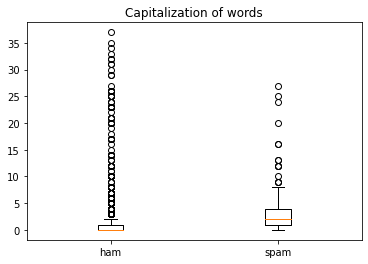

In [430]:
plt.title('Capitalization of words')
plt.boxplot(x = [ham_capitals, spam_capitals], labels = ['ham', 'spam'])
plt.show()

From the above statistics and box plot, we can see that spam messages tend to have more capitalized words than ham messages. However, ham messages have far more outliers and can have over 35 capitalized words. Therefore, capitalization is not necessarily an indication of spam. Capitalization of certain words may still be indicative of spam, however, as we will explore below. We will use the word "free" and see how many times the word is capitalized in spam messages vs ham messages.

In [431]:
# indicates the number of occurrences of 'FREE'
free_dict = {'spam': 0, 'ham': 0}

In [432]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    words = message.split(' ')
    for word in words:
        if 'free' in word.lower():                              # we split on whitespace so 'free' could be part of longer string, lowercasing to consistently find substring
            free_index = word.lower().index('free')             # getting position of 'free' substring for next step
            free = word[free_index : free_index + len('free')]  # getting slice of original string to check case
            if free.isupper():
                free_dict[label] = free_dict[label] + 1

In [433]:
print('Number of messages containing the string \'FREE\':')
free_dict

Number of messages containing the string 'FREE':


{'spam': 134, 'ham': 1}

For our example of the word 'free', this corpus has 135 instances of the word in all caps. 134/135 (~99.3%) are from spam messages. While we do not want to have to hard code these types of rules, they may provide useful features in our dataset. As a result, I am leaning towards maintaining capitalization in the dataset by creating seperate tokens for capitalized words (instead of lowercasing everything first). 

It is worth noting that there was a ham message with a capitalized 'free'. Our goal is to prevent any ham messages from being flagged as spam (false positive). If our model uses the token for capital 'FREE' as a strong indicator of , it may misclassify that message as spam. 

#### Analyzing punctuation between spam and ham messages

We will be looking for the following punctuation marks:

In [434]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [435]:
punct_dict = {'spam': 0, 'ham': 0}

In [436]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    for char in message:
        if char in string.punctuation:
            punct_dict[label] = punct_dict[label] + 1

In [437]:
print('Total number of punctuation marks for each class:')
punct_dict

Total number of punctuation marks for each class:


{'spam': 4267, 'ham': 19010}

Ham messages have more instances of punctuation but there's also way more ham messages than spam messages. Let's normalize these values by dividing by the total number of messages in each category in order to get the rate of punctuation per message.

In [438]:
for key, value in punct_dict.items():
    punct_dict[key] = value / len(df[df['spam'] == key])

In [439]:
print('Average number of punctuation marks per message:')
punct_dict

Average number of punctuation marks per message:


{'spam': 5.712182061579652, 'ham': 3.9398963730569947}

Now we can see that spam messages actually tend to have a higher number of punctuation marks than ham messages (spam messages had on average 5.7 punctuation marks per message, as opposed to 3.9 punctuation marks per message for ham messages). This is most likely due to the abundance of phone numbers, email addresses, and URL's in the spam messages. However, the presence of punctuation is not a great indicator of whether or not a message is spam because ham messages can also have lots of punctuation. We will now look into more advanced structures, such as email addresses and URL's. 

#### Analyze email address presence in messages

We will define an email address to be some combination of characters, then an '@' symbol, and then a domain name, which must start with a letter (to avoid messages like: "something@£1.50/month") and include a single period before the top level domain (like ".com" or ".com.uk"). This will convert into the following regex:

```
\S+@[a-zA-Z]\S+\.{1}\S+
```

In [440]:
email_dict = {'spam': 0, 'ham': 0}

In [441]:
email_regex = '\S+@[a-zA-Z]\S+\.{1}\S+'

In [442]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    emails = re.findall(email_regex, message)
    if not len(emails) == 0:
        print(emails)
        email_dict[label] = email_dict[label] + 1

['yijue@hotmail.com']
['info@ringtoneking.co.uk']
['tddnewsletter@emc1.co.uk']
['info@txt82228.co.uk']
['Dorothy@kiefer.com']
['msg+ticket@kiosk.Valid']
['customersqueries@netvision.uk.com']


In [443]:
print('Number of messages containing an email address:')
email_dict

Number of messages containing an email address:


{'spam': 6, 'ham': 1}

We can see here that there were actually very few email addresses in the corpus but the majority of them belonged to spam messages. While the presence of an email address does indicate that the message may be spam, there are too few instances of email addresses to make this a feature in the dataset.  

#### Analyze URL presence in messages

We will define a URL as a string that may or may not begin with https:// or http://, may or may not contain www., then some domain name. The domain name must contain one of the following: 'net', 'com', 'edu', 'co', 'gov', 'xyz', 'info', 'top'. We will define the syntax of a URL with the following regex:

```
(?:http:\/\/|https:\/\/)?(?:www\.)?\S+\.{1}(?:net|com|edu|co|gov|xyz|info|top){1}\.?\S+
```

In [444]:
url_dict = {'spam': 0, 'ham': 0}

In [445]:
url_regex = '(?:http:\/\/|https:\/\/)?(?:www\.)?\S+\.{1}(?:net|com|edu|co|gov|xyz|info|top){1}\.?\S+'

In [446]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    urls = re.findall(url_regex, message)
    if not len(urls) == 0:
        print(urls)
        url_dict[label] = url_dict[label] + 1

['xxxmobilemovieclub.com?n=QJKGIGHJJGCBL']
['yijue@hotmail.com']
['www.areyouunique.co.uk']
['www.Ldew.com1win150ppmx3age16']
['club4mobiles.com']
['info:www.100percent-real.com']
['sextextuk.com']
['www.Ldew.com1win150ppmx3age16']
['www.regalportfolio.co.uk.']
['fullonsms.com']
['www.txttowin.co.uk']
['www.07781482378.com']
['http://www.bubbletext.com']
['www.Applausestore.com']
['www.txt-2-shop.com']
['gaytextbuddy.com.']
['http://www.e-tlp.co.uk/expressoffer']
['wikipedia.com']
['www.cnupdates.com/newsletter.']
['www.getzed.co.uk']
['www.Ldew.com1win150ppmx3age16']
['www.comuk.net']
['http://www.e-tlp.co.uk/expressoffer']
['magicalsongs.blogspot.com']
['www.getzed.co.uk']
['process.networking']
['http://www.urawinner.com']
['www.txt43.com']
['1stchoice.co.uk']
['fullonsms.com']
['lucozade.co.uk/wrc']
['PocketBabe.co.uk']
['www.Ldew.com.subs16+1win150ppmx3']
['www.phb1.com']
['www.textcomp.com']
['jamster.co.uk!']
['www.ringtones.co.uk,']
['PocketBabe.co.uk']
['icicibank.com']
['icic

In [447]:
print('Number of messages containing a URL:')
url_dict

Number of messages containing a URL:


{'spam': 109, 'ham': 17}

There does appear to be a strong correlation between URL presence and spam, especially since there are far more ham messages than spam. However, there are only a total of 126 messages with a URL. We do not want to add a feature that really only applies to a small fraction of the total dataset. 

#### Analyze stop words in messages

A stop word is a word like "the", "an", "him", etc that do not add a lot of meaning to the text. We will look at home frequently stop words are used in spam vs ham messages to evaluate if removing those words will lose any valuable information.

In [448]:
stop_dict = {'spam': 0, 'ham': 0}

In [449]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [450]:
stop_words = set(stopwords.words('english'))

In [451]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [452]:
for index, row in df.iterrows():
    message = row['message']
    label = row['spam']
    words = message.split(' ')
    for word in words:
        word = word.lower()        # stopwords lists are generally lowercase
        if word in stop_words:
            stop_dict[label] = stop_dict[label] + 1

In [453]:
for key, value in stop_dict.items():
    stop_dict[key] = value / len(df[df['spam'] == key])

In [454]:
print('Number of stop words used per message:')
stop_dict

Number of stop words used per message:


{'spam': 6.420348058902276, 'ham': 5.529326424870466}

While spam messages tend to use a slightly higher number of stop words, these values are close enough that removing stop words from all the messages should not lose any valuable information. It will reduce the number of features, which should help prevent the Curse of Dimensionality. 

## Data preprocessing

From the conclusions drawn from the above data exploration, we will tokenize the messages, removing punctuation, and remove capitalization (with the exception of words that are completely capitalized like "FREE" or "URGENT", but we don't want "Free" and "free" to be separate tokens). We also need to convert the target variable, 'spam' into a 0/1.

In [455]:
# removes punctuation, removes stop words, and lowercases the word unless that word is completely capitalized
def pre_tokenize_processing(message):
    # remove punctuation
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    message = message.translate(translator)
    
    # remove stopwords
    words = message.split(' ')
    filtered_words = []
    for word in words:
        if not word in stop_words:
            filtered_words.append(word)
    
    # lowercase word unless word is completely capitalized
    
    new_words = []
    for word in filtered_words:
        if not word.isupper():     # only fails if word is completely capitalized
            word = word.lower()
        new_words.append(word)
    new_msg = ' '.join(word for word in new_words) # reconstruct message from list of new words
    return new_msg

In [456]:
# preprocess message before tokenizing
df['message'] = df.apply(lambda row: pre_tokenize_processing(row['message']), axis=1)

In [468]:
spam_map = {'ham': 0, 'spam': 1}
df['spam'] = df['spam'].map(spam_map)

In [471]:
df

,spam,message
0,0,go jurong point crazy available bugis n gre...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win FA cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,nah I think goes usf lives around though
...,...,...
5567,1,this 2nd time tried 2 contact u U £750 pound ...
5568,0,will ü b going esplanade fr home
5569,0,pity mood so suggestions
5570,0,the guy bitching I acted like interested buyin...


### Split data into train and test sets

In [472]:
X = df['message']
y = df['spam']

In [473]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

In [474]:
print('Number of rows in training dataset (these should match)')
print('X_train: ', X_train.shape[0])
print('y_train: ', y_train.shape[0])

Number of rows in training dataset (these should match)
X_train:  3343
y_train:  3343


In [475]:
print('Number of rows in test dataset (these should match)')
print('X_test: ', X_test.shape[0])
print('y_test: ', y_test.shape[0])

Number of rows in test dataset (these should match)
X_test:  2229
y_test:  2229


### Tokenizing 

min_df specifies the minimum document frequency of a word to become a token. We chose 0.0005, which means that words need to appear in at least 3 of the messages in order to become a token. max_df specifies the maximum document frequency of a word to become a token. However, since we already removed stop words, this is unlikely to have effect. We will be only generating unigrams so we are specifying the ngram_range = (1,1).

In [476]:
count_vect = CountVectorizer(lowercase=False, strip_accents='ascii', ngram_range=(1,1), max_df=0.9, min_df=0.0005)
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)       # we only call transform because we do not want to fit on the test data

In [477]:
X_train.shape

(3343, 3088)

The test set should have the same number of features because it will use the vocabulary that was created using the training set. 

In [478]:
X_test.shape

(2229, 3088)

### Converting to TF-IDF

In [479]:
tfidf_trfmr = TfidfTransformer()
X_train = tfidf_trfmr.fit_transform(X_train)
X_test = tfidf_trfmr.transform(X_test)       # we only call transform because we do not want to fit on the test data

In [480]:
X_train.shape

(3343, 3088)

Again, we should see the same number of columns here. The TF-IDF operation should not change the shape of the data.

In [481]:
X_test.shape

(2229, 3088)

This data is stored in a scipy sparse array, which is more space efficient since most of the values are zeroes. If stored in a traditional dataframe, this new dataset would take ~62 MB to store. While this is fairly modest, we may run into RAM limitations with larger datasets.

## Setting up model evaluation

**Note on evaluation metric:**

With SMS Spam detection, even a single legitimate message being blocked is unacceptable. As a result, we need to make sure we have perfect (or near perfect) precision. Obviously, we want our recall to be as high as possible but we want to put more weight on precision. As a result, we will be using an Fbeta measure with a beta value of <1 to give more weight to precision. 

In [635]:
def evaluate(predictions):
    if not len(predictions) == len(y_test):
        raise
    
    keys = list(spam_map.keys())
    
    # print classification report
    print(metrics.classification_report(y_test, predictions,
        target_names=keys, zero_division=1))

    # print confusion matrix
    cm = confusion_matrix(y_test, predictions)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(keys); ax.yaxis.set_ticklabels(keys);
    
    plt.show()
    
    # print false positive and false negative rates
    numPositives = len(np.where(y_test == 1)[0])
    numNegatives = len(np.where(y_test == 0)[0])
    
    fp = (y_test == 0) & predictions
    print('False positive rate (marked non-spam message as spam): ', len(fp[fp == 1]) / numNegatives)
    
    fn = y_test & (predictions == 0)
    print('False negative rate (failed to identify spam message): ', len(fn[fn == 1]) / numPositives)
    
    # print F1Beta score
    score = fbeta_score(y_test, predictions, beta=F1_BETA)
    print('F1 Beta Score: ', score)

## Creating a baseline model

#### Baseline 1: Trivial Rejector

The literature uses a Trivial Rejector as an initial baseline. This baseline model labels every message as ham. We will implement this to see how well it does on our data set. 

In [636]:
def tr_predict(data):
    return np.zeros(data.shape[0])

In [637]:
tr_predictions = tr_predict(X_test)

In [638]:
np.mean(tr_predictions == y_test)

0.8600269179004038

              precision    recall  f1-score   support

         ham       0.86      1.00      0.92      1917
        spam       1.00      0.00      0.00       312

    accuracy                           0.86      2229
   macro avg       0.93      0.50      0.46      2229
weighted avg       0.88      0.86      0.80      2229



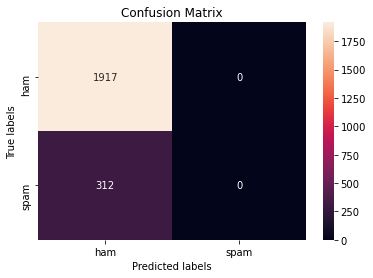

False positive rate (marked non-spam message as spam):  0.0
False negative rate (failed to identify spam message):  1.0
F1 Beta Score:  0.0


In [639]:
evaluate(tr_predictions)

Using our Trivial Rejector, we obtain an accuracy of 0.86. We obtain a false positive rate of 0, but this is only because we are labeling every message as ham. We have a false negative rate of 1.0, which means we are not finding any spam messages.

#### Baseline 2: Multinomial Naive Bayes

Naive Bayes is a popular algorithm for text classification problems. The literature also suggests that this algorithm works reasonably well on this dataset. The default scikit-learn Multinomial Naive Bayes algorithm will serve as a solid baseline for our future experiments.

In [640]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1917
        spam       1.00      0.79      0.88       312

    accuracy                           0.97      2229
   macro avg       0.98      0.90      0.93      2229
weighted avg       0.97      0.97      0.97      2229



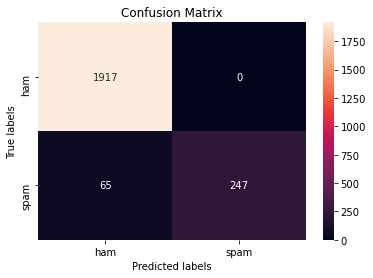

False positive rate (marked non-spam message as spam):  0.0
False negative rate (failed to identify spam message):  0.20833333333333334
F1 Beta Score:  0.9500000000000001


In [641]:
nb_predictions = nb_clf.predict(X_test)
evaluate(nb_predictions)

Using the default scikit-learn Multinomial Naive Bayes algorithm, we are actually able to achieve some pretty good results. We have a false positive rate of 0, which means we are not classifying any legitimate messages as spam. We are missing about 21% of the spam messages that come through. This will serve as a more realistic baseline model.

### Putting the above steps into a pipeline

We need to reset our dataframes back to before our transformations.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_RATIO)

In [ ]:
spam_pipeline = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('nb', MultinomialNB()),])